In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("cs109a_hw1.ipynb")

FileNotFoundError: [Errno 2] No such file or directory: 'cs109a_hw1.ipynb'

<h1 style="padding-top: 25px;padding-bottom: 25px;text-align: left; padding-left: 10px; background-color: #DDDDDD; 
    color: black;"> <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science </h1>

## Homework 1: Web Scraping, Data Parsing, and EDA

**Harvard University**<br/>
**Fall 2023**<br/>
**Instructors**: Pavlos Protopapas and Kevin Rader



<hr style='height:2px'>

#### Instructions
- To submit your assignment follow the instructions given in Canvas.
- Exercise **responsible scraping**. Web servers can become slow or unresponsive if they receive too many requests from the same source in a short amount of time. Use a short delay between requests in your code.  
- Web scraping requests can take several minutes. This is another reason why you should not wait until the last minute to do this homework.
- Plots should be legible and interpretable without having to refer to the code that generated them.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you think the plot *means*.
- The use of 'hard-coded' values to try and pass tests rather than solving problems programmatically will not receive credit.
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- Enable scrolling output on cells with very long output.
- Please remove unused cells and don't include large portions of commented-out code in your submission.
- Feel free to add additional code or markdown cells as needed.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells (this can take a few minutes).
- All cell output should be visible and it should be clear from the cell number that everything was run in order.

In [4]:
import os
import pickle
import re
import time

from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns

from warnings import simplefilter
simplefilter('ignore', category=FutureWarning)

<hr style='height:2px'>

## ⭐ Follow the stars with IMDb's list of The Top 100 Stars

### Overview
In this assignment you'll practice scraping, parsing, and analyzing HTML data pulled from web.

Specifically, you'll extract information about each person on listed on a historcal snapshot of IMDb's "starmeter", perform some EDA, ask some questions of the data, and interpret your findings.

For example, we might like to know: 
- What is the relationship between when a performer started their career and their total number of acting credits? 
- How many stars started as child actors?
- How do the distribution of ages compare across genders?
- Who is the most prolific actress or actor in the list? 

These questions and more are addressed in details below. 

## Part 1 - Scraping and Parsing

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
<div class="exercise"><b>Q1 - Scrape Top Stars List</b></div>

First, use [The Internet Archive's Wayback Machine](https://archive.org/web/) to find the URL for the September 13th, 2023 snapshot of the [IMDB starmeter page](https://www.imdb.com/chart/starmeter/). Store the URL you find as a string called `snapshot_url`.

Next, use `requests` to scrape the snapshot URL and store the resulting `Response` object as `snapshot_response`. 

Finally, store the response's status code in `status_code`.

**Note:** Checking the status code after your requests can save you time by catching problems early. Using the [headers](https://requests.readthedocs.io/en/latest/user/quickstart/#custom-headers) dictionary defined below with your requests can help provent failures when used on some pages.
</div>

In [5]:
# In this notebook, pass this as the `headers` argument when using requests.get()
headers = {'User-Agent': 'Mozilla/5.0'}

In [6]:
snapshot_url = 'https://web.archive.org/web/20230913220443/https://www.imdb.com/chart/starmeter/' # SOLUTION
snapshot_response = requests.get(snapshot_url, headers=headers) # SOLUTION
status_code = snapshot_response.status_code  # SOLUTION

In [7]:
# It's always a good idea to check your status code!
print(f"Response statuse code: {status_code}")

Response statuse code: 200


In [8]:
grader.check("q1")

NameError: name 'grader' is not defined

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
<div class='exercise'><b>Q2 - Making BeautifulSoup</b></div>

Create a Beautiful Soup object named `star_soup` from the HTML content in `snapshot_response`.


In [9]:
star_soup = BeautifulSoup(snapshot_response.content, "html.parser") # SOLUTION

In [10]:
# Taste the soup! You should see HTML code here
print(star_soup.prettify()[:1000])

<!DOCTYPE html>
<html lang="en-US" xmlns:fb="http://www.facebook.com/2008/fbml" xmlns:og="http://opengraphprotocol.org/schema/">
 <head>
  <script charset="utf-8" src="/_static/js/bundle-playback.js?v=1WaXNDFE" type="text/javascript">
  </script>
  <script charset="utf-8" src="/_static/js/wombat.js?v=txqj7nKC" type="text/javascript">
  </script>
  <script>
   window.RufflePlayer=window.RufflePlayer||{};window.RufflePlayer.config={"autoplay":"on","unmuteOverlay":"hidden"};
  </script>
  <script src="/_static/js/ruffle.js" type="text/javascript">
  </script>
  <script type="text/javascript">
   __wm.init("https://web.archive.org/web");
  __wm.wombat("https://www.imdb.com/chart/starmeter/","20230913220443","https://web.archive.org/","web","/_static/",
	      "1694642683");
  </script>
  <link href="/_static/css/banner-styles.css?v=S1zqJCYt" rel="stylesheet" type="text/css"/>
  <link href="/_static/css/iconochive.css?v=qtvMKcIJ" rel="stylesheet" type="text/css"/>
  <!-- End Wayback Rewrite

In [ ]:
grader.check("q2")

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
<div class='exercise'><b>Q3 - Parse Stars</b></div>

Implement the `parse_stars` function described below, pass it your `star_soup`, and save the result in a variable called `star_list`. 

>**Note:** We use the 'fullcredits' URL for credits rather than the main star page which would require browser automation to extract all credits.
>
>**Hint:** Throughout this assignment you'll likely find it useful to create small 'helper' functions which are then used by your larger functions like `parse_stars`

```
Function
--------
parse_stars

Input
------
star_soup: BeautifulSoup object created from starmeter page
   
Returns
-------
a list of dictionaries; each dictionary corresponds to a listed star with the following data:

    name: (str) the name of the star
    roles: (list) star's roles (lowercase) in the order they appear on starmeter
    star_url: (str) current URL (non-snapshot) linked by star's name (exclude '/?' query)
    credits_url: (str) current URL of star's simplified credits page

Example Output:
--------

[
...
{'name': 'Diana Lee Inosanto',
 'roles': ['actress', 'director', 'producer'],
 'star_url': 'https://www.imdb.com/name/nm0409262',
 'credits_url': 'https://www.imdb.com/name/nm0409262/fullcredits'},
...
]

```
</div>

In [11]:
# Implement parse_stars
def parse_stars(star_soup) -> list:
    # BEGIN SOLUTION
    get_name = lambda x: x.select_one('.ipc-title').text.strip()
    get_roles = lambda x: [r.text.lower() for r in x.select_one('.ipc-inline-list').select('li')]
    get_url = lambda x: '/'.join(x.select_one('a').get('href').split('/')[3:-1])
    
    stars = star_soup.select('.ipc-metadata-list-summary-item')
    starlist = []
    for i, s in enumerate(stars, start=1):
        d = {}
        d['name'] = get_name(s)
        print(str(i).rjust(3) + ': ' + d['name'].ljust(25), end='')
        d['roles'] = get_roles(s)
        print("\tdone!")
        d['star_url'] = get_url(s)
        d['credits_url'] = d['star_url'] + '/fullcredits'
        starlist.append(d)
    return starlist
    # END SOLUTION

In [12]:
# Construct star_list
star_list = parse_stars(star_soup) # SOLUTION

  1: Emily Rudd               	done!
  2: Mary Elizabeth Winstead  	done!
  3: Morgan Davies            	done!
  4: Mackenyu                 	done!
  5: Iñaki Godoy              	done!
  6: Danny Masterson          	done!
  7: Bijou Phillips           	done!
  8: Stephanie Nur            	done!
  9: Jeff Ward                	done!
 10: Natasha Liu Bordizzo     	done!
 11: Ivanna Sakhno            	done!
 12: Ray Stevenson            	done!
 13: Taz Skylar               	done!
 14: Sophie Turner            	done!
 15: Jackie Sandler           	done!
 16: Vincent Regan            	done!
 17: Rosario Dawson           	done!
 18: Celeste Loots            	done!
 19: Sasha Calle              	done!
 20: Florence Pugh            	done!
 21: Rosamund Pike            	done!
 22: Evin Ahmad               	done!
 23: Peter Gadiot             	done!
 24: Annabelle Wallis         	done!
 25: Denzel Washington        	done!
 26: Jennifer Lawrence        	done!
 27: Jonah Hauer-King         	done!
 

In [13]:
# Inspect one list entry
star_list[42]

{'name': 'Diana Lee Inosanto',
 'roles': ['actress', 'director', 'producer'],
 'star_url': 'https://www.imdb.com/name/nm0409262',
 'credits_url': 'https://www.imdb.com/name/nm0409262/fullcredits'}

In [ ]:
grader.check("q3")

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
<div class='exercise'><b>Q4 - Add BeautifulSoup Pages</b></div>

Now, we'd like to update each dictionary in `star_list` to include a BeautifulSoup object corresponding to that star's `star_url` and `credits_url`. We'll use the keys `star_page` and `credits_page` for these new entries in the dictionaries.

To accomplish this, implement the `add_pages` function below which takes the current `star_list` and returns a new list with the updated dictionaries.

Code we've provided will then use your `add_pages` implementation to create `star_pages`, which is what we'll call the list with the updated dictionaries.
</div>

In [14]:
def add_pages(star_list) -> list:
    # BEGIN SOLUTION
    def get_page(url):
        print("\tgetting page...", end='')
        result = requests.get(url, headers=headers)
        assert result.status_code == 200, "GET request failed"
        soup = BeautifulSoup(result.content, 'html.parser')
        print('done!')
        return soup
        
    for d in star_list:
        print(f"{d['name']}:")
        d['star_page'] =  get_page(d['star_url'])
        time.sleep(0.5)
        d['credits_page'] = get_page(d['credits_url'])
        time.sleep(0.5)
    return star_list
    # END SOLUTION

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
Scraping all these pages can take 5-10 minutes if you're using a small delay between requests with `time.sleep`(as you should!).

To prevent you from having to re-scrape this data everytime you run your notebook we've provided some code below.

The code first checks if a [pickle file](https://docs.python.org/3/library/pickle.html), `star_pages.pkl`, exists from a previous scraping. If it does, it'll try to load from it. If the file doesn't exist, if there's any error during loading, or if the loaded `star_pages` doesn't have 100 entries, it'll run your `add_pages` scraping function and save the results to the pickle file.

**Note:** The code will load your pickle file and assume everything is fine as long as it contains 100 entries, but it does not check the entries themselves. If there are issues with the entries themselves, you'll need to delete your current pickle file so that you can re-scrape.
</div>

In [ ]:
# Provided code
def save_to_pickle(data, filename):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)

def load_from_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

# Check if pickle file exists
pickle_filename = "star_pages.pkl"
SCRAPE = True # assume we're scraping

#unless we have a good pkl file
if os.path.exists(pickle_filename):
    try:
        star_pages = load_from_pickle(pickle_filename)
        assert len(star_pages) == 100, "star_pages should have 100 entries!"
        print("Pickle file of previous scraping loaded!")
        SCRAPE = False
    except Exception as e:
        print(f"Error loading from pickle: {e}. Will re-scrape data.")

if SCRAPE:
    start_time = time.time()
    # Here is where your scraping function is run
    star_pages = add_pages(star_list)
    end_time = time.time()
    scraping_time = round((end_time-start_time)/60, 2)
    print(f"Scraping took {scraping_time} minutes!")
    save_to_pickle(star_pages, pickle_filename)

Emily Rudd:
	getting page...done!
	getting page...done!
Mary Elizabeth Winstead:
	getting page...done!
	getting page...done!
Morgan Davies:
	getting page...done!
	getting page...done!
Mackenyu:
	getting page...done!
	getting page...done!
Iñaki Godoy:
	getting page...done!
	getting page...done!
Danny Masterson:
	getting page...done!
	getting page...done!
Bijou Phillips:
	getting page...done!
	getting page...done!
Stephanie Nur:
	getting page...done!
	getting page...done!
Jeff Ward:
	getting page...done!
	getting page...done!
Natasha Liu Bordizzo:
	getting page...done!
	getting page...done!
Ivanna Sakhno:
	getting page...done!
	getting page...done!
Ray Stevenson:
	getting page...done!
	getting page...done!
Taz Skylar:
	getting page...done!
	getting page...done!
Sophie Turner:
	getting page...done!
	getting page...done!
Jackie Sandler:
	getting page...done!
	getting page...done!
Vincent Regan:
	getting page...done!
	getting page...done!
Rosario Dawson:
	getting page...done!
	getting page.

In [ ]:
grader.check("q4")

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
<div class='exercise'><b>Q5 - Parse Star Pages</b></div>

Implement the function `parse_star_pages` described below, which takes `star_pages` as an input and returns a *new* list of dictionaries, `star_data`, which includes more extensive information about each star extracted from their `star_page` and `credits_page`. 

```
Function
--------
create_star_data

Input
------
star_pages (list of dictionaries)
   
Returns
-------

a list of dictionaries; each dictionary corresponds to a star profile and has the following data:

    name: (str) the name of the star
    primary_role: (str) type of role this star is most known for (see note about heuristic below)
    roles: (str) all role types for this star listed on starmeter page
    gender: (str) 'woman', 'man', 'non-binary', or 'unknown' (we provide a helper function)  
    year_born : (int/str) year star was born or 'unknown' if not included on star_page
    first_credit: (str) title of their first credit in their capacity designated by 'primary_role'
    year_first_credit: (int) year of their first credit in their capacity designated by 'primary_role'
    num_credits: (int) number of movie or TV show recieved in their capacity designated by 'primary_role'
    
--------
Example:
[
...
{'name': 'Brad Pitt',
 'primary_role': 'actor',
 'roles': ['producer', 'actor', 'executive'],
 'gender': 'male',
 'year_born': 1963,
 'first_credit': 'Hunk',
 'year_first_credit': 1987,
 'num_credits': 87}
]
```
</div>

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
    
>**Additional Implementation Notes:** 
>
>**Gender**
>- We have provided a helper function, `get_gender()`, for trying to infer gender from a given `star_page`. You may find it useful to create additional helper functions for `parse_stars` to populate the other values. You'll find that any additional helper functions you need to write will not need to be as complex as `get_gender()`.
>
>**Primary Role**
>- IMDb is primarily concerned with TV and film roles, and really, no one is a star *because* they are a producer. Use the following heuristic for determining a star's primary role: select the first role type listed on the starmeter page excluding 'music artist' and 'producer'. This will produce at least one questionable result, but that is fine.
>
>**Credits**
>- For TV credits, you don't need to consider individual episodes. You can treat the TV show as a whole as a single credit.
>- The years of some credits are ranges (e.g., 2001-2002). You should use only the starting year.

>**Hint:** Carefuly note the ordering, case, and data type of the values in each dictionary.
</div>

In [24]:
# Helper functions
def get_gender(star_page, page=None):
    # some pages have a gender identity field
    # this actually saves us in some cases where counting pronouns fails
    # due to limited bio
    gi_span = star_page.find('span', string='Gender / Gender identity')
    if gi_span is not None:
        return gi_span.next_sibling()[-1].text.lower()

    # otherwise we count pronouns
    PRONOUNS = {'female': ['she', 'her', 'hers'],
                'male': ['he', 'him', 'his'],
                'non-binary': ['they', 'them', 'their']}
    
    def count_pronouns(bio):
        pronoun_counts = [len(re.findall(rf"\W({'|'.join(pns)})\W", bio)) for pns in PRONOUNS.values()]
        return pronoun_counts

    bio = star_page.select_one('.ipc-html-content-inner-div').text.lower()
    pronoun_counts = count_pronouns(bio)
    # if no pronoun counts in bio
    if sum(pronoun_counts) == 0:
        # IMDB seems to treat 'Actor' as gender neutral, but not 'Actress'
        # Usinger 'Actor' to infer gender will get you the wrong results
        # (see Sept 4th starmeter snapshot for example)
        if star_page.find('h3', string='Actress') is not None:
            return 'female' 
        else:
            return 'unknown'
    return list(PRONOUNS.keys())[np.argmax(pronoun_counts)]

# BEGIN SOLUTION NO PROMPT
def get_year_born(soup):
    try:
        # dob = int(re.findall(r'\d{4}', soup.find(attrs={"data-testid":"birth-and-death-birthdate"}).select('span')[-1].text)[0])
        dob = int(re.findall(r'\d{4}', soup.find('span', string='Born').next_sibling.text)[0])
    except:
        dob = 'unknown'
    return dob

def get_primary_role(star_dict):
    roles = star_dict['roles']
    # Ignore the producer and music artist roles
    roles = [r for r in roles if r not in ['producer', 'music artist']]
    primary_role = roles[0]
    return primary_role

def get_credit_year(tag):
    year = tag.select_one('.year_column').text.strip()
    if year == '':
        year = 'TBD'
    else:
        # some years are strange. e.g. "2023/I"
        year = int(re.search('\d{4}', year)[0])
    return year

def get_credit_info(star_dict):
    primary_role = get_primary_role(star_dict)
    works = star_dict['credits_page'].select_one(f"#filmo-head-{primary_role}").find_next_sibling().select('.filmo-row')
    credits = [(tag.b.text, get_credit_year(tag)) for tag in works]
    num_credits = len(credits)
    first_credit, year_first_credit = credits[-1]
    return num_credits, first_credit, year_first_credit
    
def get_star_data(star_dict: dict):
    d = {}
    d['name'] = star_dict['name']
    d['primary_role'] = get_primary_role(star_dict)
    d['roles'] = star_dict['roles']
    d['gender'] = get_gender(star_dict['star_page'])
    d['year_born'] = get_year_born(star_dict['star_page'])
    # perhaps easiest to gather all credit info at once
    num_credits, first_credit, year_first_credit = get_credit_info(star_dict)
    d['first_credit'] = first_credit
    d['year_first_credit'] = year_first_credit
    d['num_credits'] = num_credits
    return d
# END SOLUTION

In [25]:
def parse_star_pages(star_pages: list) -> list:
    # BEGIN SOLUTION 
    star_data = []
    for s in star_pages:
        try:
            d = get_star_data(s)
            star_data.append(d)
        except Exception as e:
            print(e)
            print(s['name'])
    return star_data
    # END SOLUTION

In [26]:
star_data = parse_star_pages(star_pages) # SOLUTION

In [27]:
# Inspect an element from star_data
star_data[-1]

{'name': 'Brad Pitt',
 'primary_role': 'actor',
 'roles': ['producer', 'actor', 'executive'],
 'gender': 'male',
 'year_born': 1963,
 'first_credit': 'Hunk',
 'year_first_credit': 1987,
 'num_credits': 87}

In [ ]:
grader.check("q5")

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
<div class='exercise'><b>Q6 - Creating a DataFrame and Saving a CSV</b></div>

Use `star_data` to create a Pandas DataFrame called `star_df` and save it to disk as `data/star_data.csv`.

In [41]:
# BEGIN SOLUTION
star_df = pd.DataFrame(star_data)
star_df.to_csv("data/star_data.csv", index=False)

## Some manual corrections for the staff DataFrame
staff_star_df = star_df.copy()
# Manually add some missing birth years
staff_star_df.loc[staff_star_df.year_born == 'unknown', "year_born"] = [1985,2007, 1990, 1966, 1984, 1996]

# Scott's IMDb bio is very short, but other sources consistently refer to Scott with "he/him"
staff_star_df.loc[staff_star_df.gender == 'unknown', "gender"] = "male"

# Nolan is known as a director, not a writer
staff_star_df.loc[staff_star_df.name == "Christopher Nolan", "primary_role"] = "director"

# First credit year is voice acting for an English release
# of a movie made before Fanning was born!
staff_star_df.loc[staff_star_df.name == "Dakota Fanning", "year_first_credit"] = 2000
staff_star_df.loc[staff_star_df.name == "Dakota Fanning", "first_credit"] = 'ER'
# Write staff file
staff_star_df.to_csv("data/star_data_2023_staff.csv", index=False)
# END SOLUTION

In [ ]:
grader.check("q6")

## Part 2 - Pandas & EDA

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
<div class='exercise'><b>Q7 - Load CSV</b></div>

For the sake of consistency, we've provide our own CSV file, `data/star_data_2023_staff.csv`, which you should use for the rest of the notebook. Use this CSV to create a Pandas DataFrame called `df`. 
</div>

In [43]:
df = pd.read_csv('data/star_data_2023_staff.csv') # SOLUTION

In [44]:
# Take a peek
df.head(20)

,name,primary_role,roles,gender,year_born,first_credit,year_first_credit,num_credits
0,Emily Rudd,actress,['actress'],female,1993,Boy & Bear: Three Headed Woman,2013,26
1,Mary Elizabeth Winstead,actress,"['actress', 'producer', 'soundtrack']",female,1984,Touched by an Angel,1997,59
2,Morgan Davies,actor,"['actor', 'second unit director or assistant d...",male,2001,Green Fire Envy,2008,19
3,Mackenyu,actor,"['actor', 'soundtrack']",male,1996,Astro kyûdan,2005,46
4,Iñaki Godoy,actor,['actor'],male,2003,Blue Demon,2016,11
5,Danny Masterson,actor,"['actor', 'producer', 'soundtrack']",male,1976,Jake and the Fatman,1988,68
6,Bijou Phillips,actress,"['actress', 'costume and wardrobe department',...",female,1980,Sublime: Wrong Way,1997,38
7,Stephanie Nur,actress,['actress'],female,1988,Tanzcafe Jenseits,2009,13
8,Jeff Ward,actor,"['actor', 'writer', 'producer']",male,1986,Law & Order: Criminal Intent,2005,31
9,Natasha Liu Bordizzo,actress,['actress'],female,1994,"Crouching Tiger, Hidden Dragon: Sword of Destiny",2016,16


In [ ]:
grader.check("q7")

<!-- BEGIN QUESTION -->

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
<div class='exercise'><b>Q8 - Age at First Credit</b></div>

Add a new column to your dataframe with the *approximate* age of each star at the time of their first credit. Name this new column `age_at_first_credit`.

Next, creat a visualization which compares each `age_at_first_credit` across the 100 stars. You'll need to make some choices as to what makes a useful and legible plot.

>**NOTE:** We say *approximate* age because we've only collected the year of birth as several star pages do not include a full birth date. **The approximate age of a star in a given year should be the difference between that year and the star's birth year.**
</div>

In [46]:
# add age_at_first_credit column
# BEGIN SOLUTION
df['age_at_first_credit'] = df.year_first_credit - df.year_born
# END SOLUTION

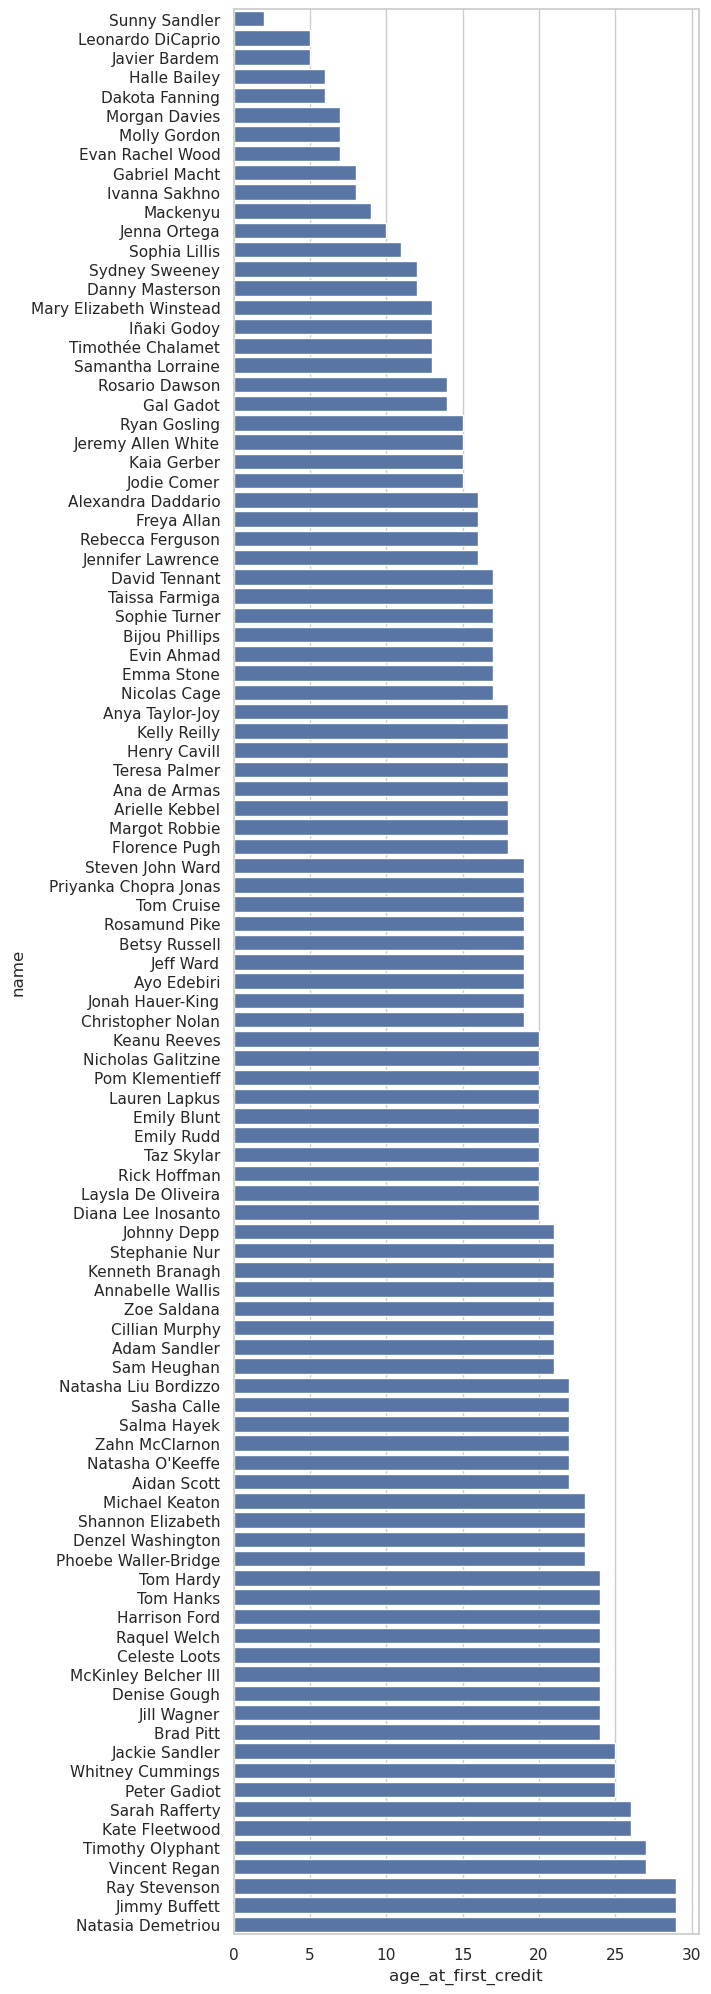

In [47]:
# Visualize the new column values
# BEGIN SOLUTION
sns.set(style='whitegrid')
f, ax = plt.subplots(figsize=(6, 25))
sns.barplot(x='age_at_first_credit',
            y='name',
            data=df.sort_values(by=['age_at_first_credit'], ascending=True),
            label='Age At First Credit',
            color='b');
# END SOLUTION

In [48]:
# You should visually inspect the values too
df.head()

,name,primary_role,roles,gender,year_born,first_credit,year_first_credit,num_credits,age_at_first_credit
0,Emily Rudd,actress,['actress'],female,1993,Boy & Bear: Three Headed Woman,2013,26,20
1,Mary Elizabeth Winstead,actress,"['actress', 'producer', 'soundtrack']",female,1984,Touched by an Angel,1997,59,13
2,Morgan Davies,actor,"['actor', 'second unit director or assistant d...",male,2001,Green Fire Envy,2008,19,7
3,Mackenyu,actor,"['actor', 'soundtrack']",male,1996,Astro kyûdan,2005,46,9
4,Iñaki Godoy,actor,['actor'],male,2003,Blue Demon,2016,11,13


In [ ]:
grader.check("q8")

<!-- END QUESTION -->

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
<div class='exercise'><b>Q9 - Subsetting and Sorting</b></div>

In this section you'll subset and sort the DataFrame to answer a pair of questions:
</div>

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
<div class='exercise'><b>Q9.1 - Child Stars</b></div>

Which stars received their first credit **before the age of 11?**

Store the resulting dataframe as `child_stars`sorted by `age_at_first_credit` in **ascending** order.\
Store the number of such "child stars" in `num_child_stars`.
</div>

In [50]:
child_stars = df[df['age_at_first_credit'] < 11].sort_values('age_at_first_credit') # SOLUTION
num_child_stars = child_stars.shape[0] # SOLUTION

print ("{} stars received their first credit before the age of 11.".format(num_child_stars))
display(child_stars)

12 stars received their first credit before the age of 11.


,name,primary_role,roles,gender,year_born,first_credit,year_first_credit,num_credits,age_at_first_credit
89,Sunny Sandler,actress,['actress'],female,2008,Grown Ups,2010,22,2
44,Javier Bardem,actor,"['actor', 'producer', 'music department']",male,1969,El pícaro,1974,74,5
86,Leonardo DiCaprio,actor,"['producer', 'actor', 'writer']",male,1974,Romper Room,1979,47,5
32,Halle Bailey,actress,"['actress', 'composer', 'music department']",female,2000,Last Holiday,2006,18,6
39,Dakota Fanning,actress,"['actress', 'producer', 'director']",female,1994,ER,2000,72,6
2,Morgan Davies,actor,"['actor', 'second unit director or assistant d...",male,2001,Green Fire Envy,2008,19,7
82,Molly Gordon,actress,"['actress', 'writer', 'director']",female,1994,I Am Sam,2001,23,7
84,Evan Rachel Wood,actress,"['actress', 'director', 'writer']",female,1987,"In the Best of Families: Marriage, Pride & Mad...",1994,66,7
10,Ivanna Sakhno,actress,"['actress', 'producer']",female,1997,Lesya plyus Roma,2005,21,8
31,Gabriel Macht,actor,"['actor', 'producer', 'director']",male,1972,Why Would I Lie?,1980,35,8


In [ ]:
grader.check("q9.1")

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
<div class='exercise'><b>Q9.2 - Late Bloomers</b></div>

Which stars received their first credit at **26-years-old or older?**

Store the resulting dataframe as `late_bloomers` sorted by `age_at_first_credit` in **descending** order.\
Store the number of such "late bloomers" in `num_late_bloomers`.
</div>

In [52]:
late_bloomers = df[df['age_at_first_credit'] >= 26].sort_values('age_at_first_credit', ascending=False) # SOLUTION
num_late_bloomers = late_bloomers.shape[0] # SOLUTION

print ("{} stars received their first credit at 26 or older.".format(num_late_bloomers))
display(late_bloomers)

7 stars received their first credit at 26 or older.


,name,primary_role,roles,gender,year_born,first_credit,year_first_credit,num_credits,age_at_first_credit
11,Ray Stevenson,actor,"['actor', 'soundtrack']",male,1964,A Woman's Guide to Adultery,1993,64,29
54,Natasia Demetriou,actress,"['actress', 'writer', 'director']",female,1984,Jamie Demetriou: Channel 4 Comedy Blaps,2013,35,29
71,Jimmy Buffett,actor,"['music artist', 'actor', 'producer']",male,1946,Rancho Deluxe,1975,18,29
15,Vincent Regan,actor,"['actor', 'director', 'writer']",male,1965,Between the Lines,1992,116,27
83,Timothy Olyphant,actor,"['actor', 'producer', 'soundtrack']",male,1968,77 Sunset Strip,1995,76,27
67,Sarah Rafferty,actress,"['actress', 'producer', 'soundtrack']",female,1972,Trinity,1998,37,26
70,Kate Fleetwood,actress,"['actress', 'soundtrack']",female,1972,Getting Hurt,1998,55,26


In [ ]:
grader.check("q9.2")

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
<div class='exercise'><b>Q10 - Visualization  </b></div>

In this section you'll use your Python visualization skills to further explore the data:
</div>

<!-- BEGIN QUESTION -->

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
<div class='exercise'><b>Q10.1  - Exploring Trends</b></div>

Create 2 [scatter plots](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.scatter.html?highlight=scatter#matplotlib.axes.Axes.scatter): one showing the relationship between **age at first movie** and number of credits, the other between **year born** and number of credits.

What can you say about these relationships? Are there any apparent outliers? Please limit your written responses to 4 sentences or fewer.
</div>

<div style='color:blue'>
There is no obvious relationship between `age_at_first_credit` and `num_credits`, but there is a negative relationship between `year_born` and `num_credits`. This is not surprising as younger stars have had fewer years to accumulate credits! There do not appear to be any extreme outliers.
</div>

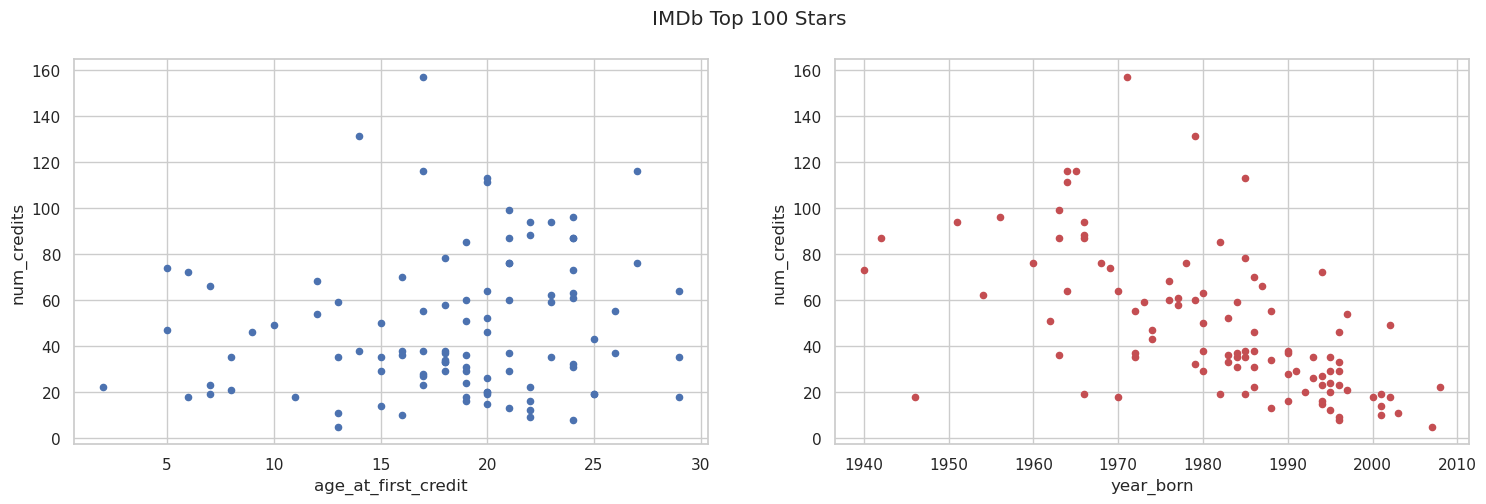

In [54]:
# your code here
# BEGIN SOLUTION NO PROMPT
fig, axes = plt.subplots(1,2, figsize=(18,5))
df.plot(x='age_at_first_credit', y='num_credits', kind='scatter', c='b', ax=axes[0]);
df.plot(x='year_born', y='num_credits', kind='scatter', c='r', ax=axes[1])
plt.suptitle("IMDb Top 100 Stars");
# END SOLUTION

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
<div class='exercise'><b>Q10.2 - Age Distributions</b></div>

Let's look at the distribution of movie and TV performers' ages by gender.

Create two plots, each plot consisting of **two overlayed [histograms](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html?highlight=hist#matplotlib.pyplot.hist)** comparing the distribution of men's current ages to women's current ages.

In the first plot, the distributions should be normalized to show the *proportion* of each gender at each age.

The second plot should show the *counts* of each gender at each age. 

Finallu, interpret the resulting plots. (4 sentences or fewer)

>**NOTE 1:** Again, we are dealing with *approximate* ages as defined above.
>
>**NOTE 2:** You should exclude those whose `primary_role` is not 'actor' or 'actress' from your analysis
</div>

**Note:** For the 1st histogram either proportion or density would have been acceptable.

<div style='color:blue'>
If we 'bin' ages by decade we can see that most of the women are in their thirties while most of the men are in their fifties. In general, the age distribution for men compared to women is shifted to the right (i.e., older). We can also see by comparing the proportion and density plots to the count plot that their are far more women in the IMDb Top 100 Stars list than men. Students did not need both a density and proportion plot; one or the other would be sufficient to complement the count plot.
</div>

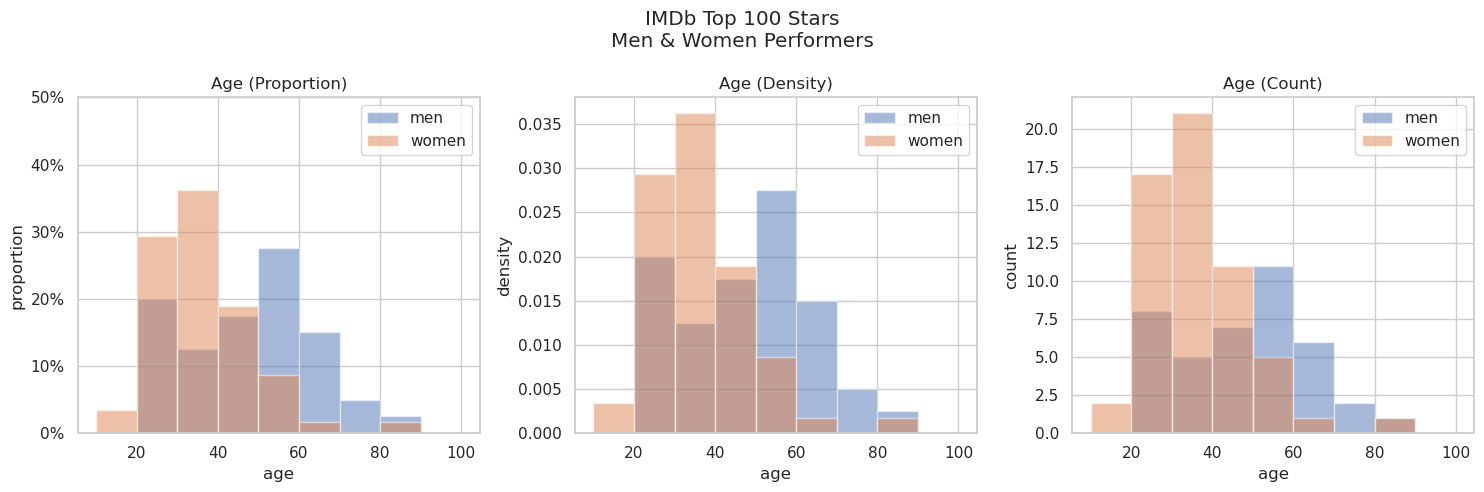

In [55]:
# your code here

# BEGIN SOLUTION NO PROMPT
performers = df[df.primary_role.str.lower().isin(['actor', 'actress'])]
women_ages = 2023 - performers[performers.gender == 'female'].year_born
men_ages = 2023 - performers[performers.gender == 'male'].year_born

fig, axes = plt.subplots(1,3, figsize=(15,5))

for ylabel, ax in zip(['proportion', 'density', 'count'], axes):
    for group, data in {'men': men_ages, 'women': women_ages}.items():
        _, _, patches = ax.hist(data, alpha=0.5, bins=range(10,101,10), label=group, density=(ylabel == 'density'));
        # if proportion, rescale heights and adjust y-axis
        # This method will work regardless of the number/location of bins used
        if ylabel == 'proportion':
            [c.set_height(c.get_height()/len(data)) for c in patches.get_children()]
            ax.yaxis.set_major_formatter('{x:.0%}')
            ax.set_ylim(0,0.5)
        ax.set(ylabel=ylabel, xlabel='age', title=f'Age ({ylabel.capitalize()})');
        ax.legend()
plt.suptitle("IMDb Top 100 Stars\nMen & Women Performers");
plt.tight_layout()
# END SOLUTION

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
<div class='exercise'><b>Q10.3 - Credits Per Year</b></div>

Create a [box plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.boxplot.html?highlight=boxplot#matplotlib.axes.Axes.boxplot) or [violin plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.violin.html?highlight=violin#matplotlib.axes.Axes.violin) comparing the **credits-per-year-active** for men and women performers.

Here we assume all stars in the list are still active. 

Do these distributions look the same across genders? Can you identify the stars corresponding to any outliers? Comment on these points and anything else of interest gleaned from your plot. (6 sentences or fewer)

>**NOTE:** Again, you should exclude those whose `primary_role` is not 'actor' or 'actress' from your analysis.
</div>

<div style='color:blue'>
    
Women have a slightly higher median credits-per-year-active (CBYA) with ~2.3 compared to slightly less than 2 for men. The distribution for men is a bit less and a bit more symmetrical while the distribution for women is more right skewed with some women in the 4th quartile having made an additional movie per year active than men in the 4th quartile. The outlier among the women is also more extreme: David Tennant has roughly 4.5 CPYA while Lauren Lapkus, the outlier among the women, has almost 6.5 CPYA! This high number seems to be a result of Lauren Lapkus doing primarily TV work, voice acting for animated shows, and podcasts (which IMDb includes under her actress credits). The production time on these projects is much shorter than a 'feature fim' so more of them can fit into a year's work.
</div>

Outliers


,name,primary_role,roles,gender,year_born,first_credit,year_first_credit,num_credits,age_at_first_credit,years_active,cpya
66,David Tennant,actor,"['actor', 'producer', 'director']",male,1971,Dramarama,1988,157,17,35,4.485714


,name,primary_role,roles,gender,year_born,first_credit,year_first_credit,num_credits,age_at_first_credit,years_active,cpya
76,Lauren Lapkus,actress,"['actress', 'music department', 'writer']",female,1985,Movie Boy,2005,113,20,18,6.277778


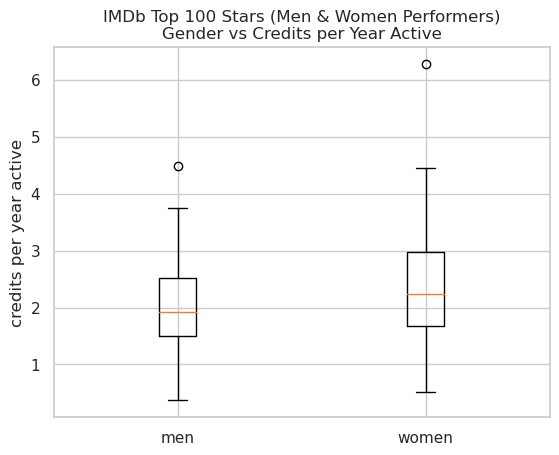

In [56]:
# your code here
# BEGIN SOLUTION NO PROMPT
performers = performers.assign(years_active=lambda x: 2023 - x.year_first_credit,
                  cpya=lambda x: x.num_credits / x.years_active)

boxplot = plt.boxplot([performers[performers.gender =='male'].cpya,
                       performers[performers.gender == 'female'].cpya])
plt.title('IMDb Top 100 Stars (Men & Women Performers)\nGender vs Credits per Year Active')
plt.xticks(ticks=[1,2], labels=['men', 'women'])
plt.ylabel('credits per year active');


def get_outliers(df, col):
    Q1 = df[col].quantile(.25)
    Q3 = df[col].quantile(.75)
    IQR = Q3 - Q1
    return df[(df[col] < Q1-1.5*IQR) | (df[col] > Q3 + 1.5*IQR)]

print("Outliers")
display(get_outliers(performers[performers.gender == 'male'], 'cpya'))
display(get_outliers(performers[performers.gender == 'female'], 'cpya'))
# END SOLUTION

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
<div class='exercise'><b>Q11 - Most Prolific Stars</b></div>

Make a plot visualizing the number of credits received by each star. Who is the most prolific person in our snapshot of IMDb's starmeter? Define **most prolific** as the person with the most credits.

>**Note 1:** Your analysis should include all 100 stars
>
>**Note 2:** The stars in the plots should be sorted based on number of credits to make the plot easier to read.
</div>

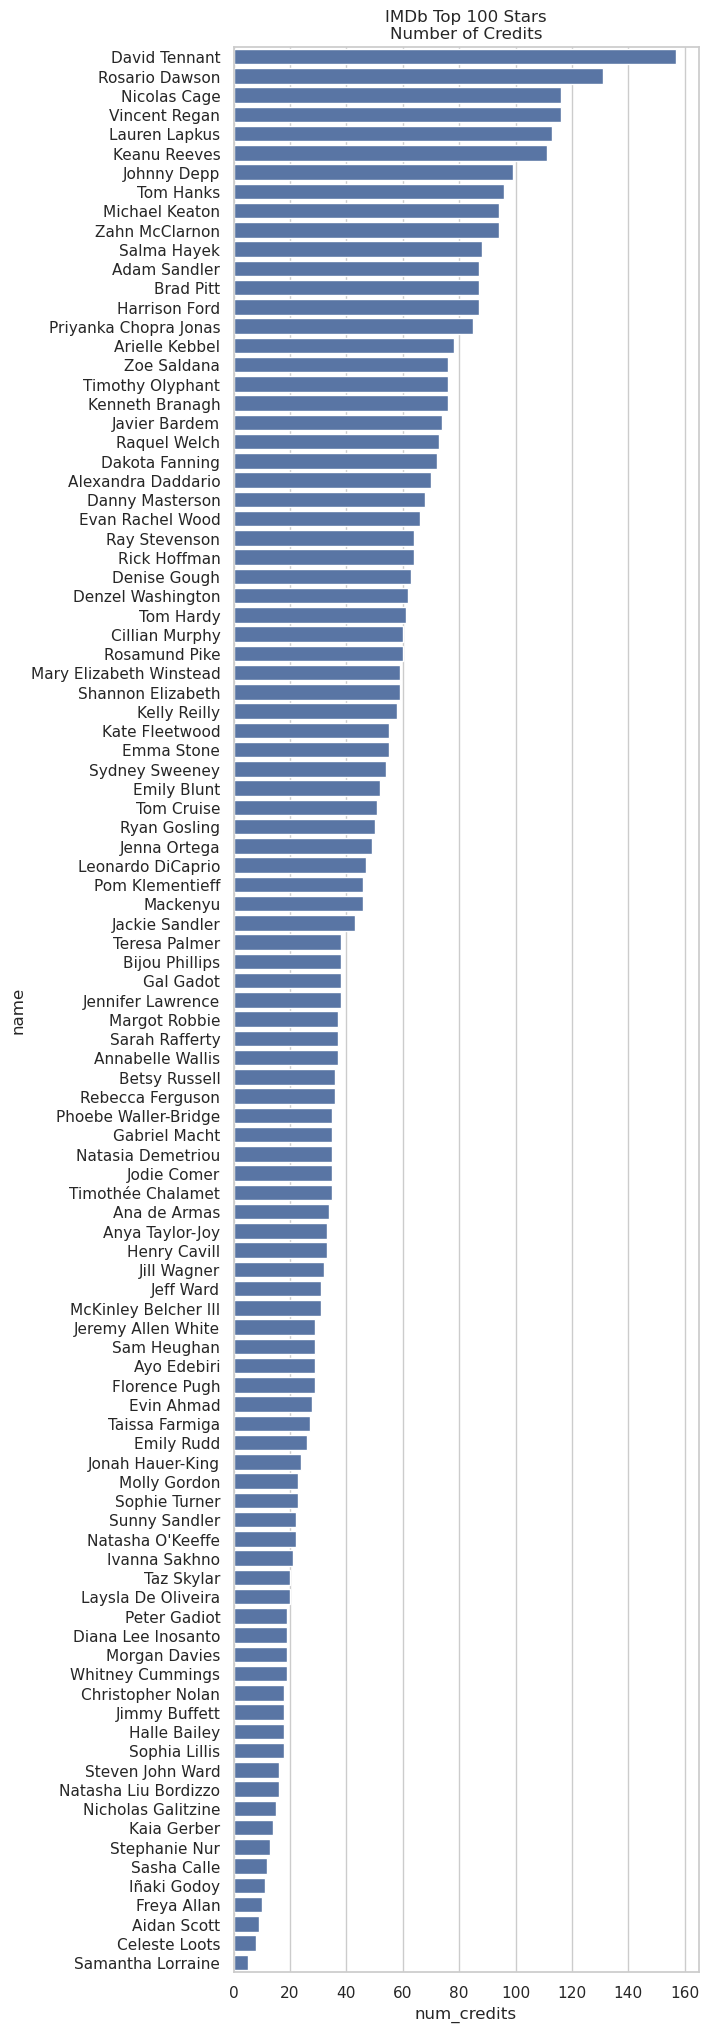

In [57]:
# your code here
# BEGIN SOLUTION NO PROMPT
sns.set(style='whitegrid')

# initialize the figure
fig, ax = plt.subplots(figsize=(6, 25))

sns.barplot(x='num_credits',
            y='name',
            data=df.sort_values(by=['num_credits'], ascending=False),
            label='Credits',
            color='b',
            ax=ax);
ax.set_title("IMDb Top 100 Stars\nNumber of Credits");
# END SOLUTION

In [58]:
highest_performer_name = df.name[df.num_credits.idxmax()] # SOLUTION
highest_performer_credits = df.num_credits[df.num_credits.idxmax()] # SOLUTION
print ("{} had the most credits with {}".format(highest_performer_name, highest_performer_credits))

David Tennant had the most credits with 157


<!-- END QUESTION -->

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
<div class='exercise'><b>🌈 BONUS - Additional EDA (ungraded)</b></div>

Feel free to use this space to perform additional EDA. We will share any of your interesting insights or visualizations with the rest of the class!
</div>

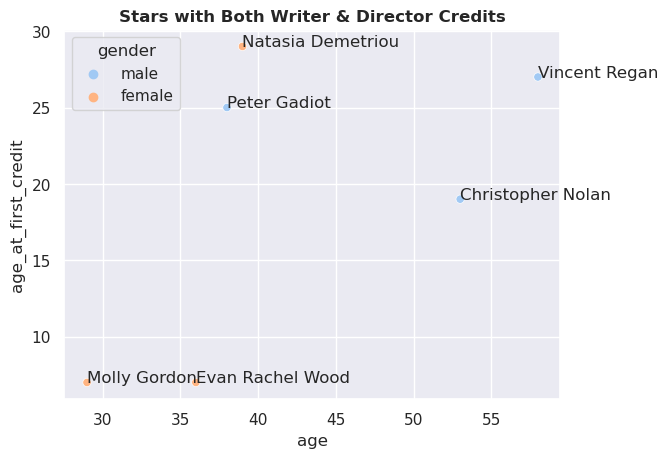

In [59]:
# your (optional) code here
df['age'] = 2023- df['year_born']
mask = df.roles.str.contains('director') & df.roles.str.contains('writer')
sns.set_theme(style='darkgrid', palette='pastel')
ax = sns.scatterplot(data=df[mask], x='age', y='age_at_first_credit', hue='gender')
for i, row in df[mask].iterrows():
  ax.annotate(row['name'], (row.age, row.age_at_first_credit))  
ax.set_title("Stars with Both Writer & Director Credits", fontdict={'fontweight': 'bold'});

There are an equal number of women with both writer and director credits as there are men. There are three in each group as infered from both writer and director being listed in their roles. The age distribution looks similar to those seen among the actors and actresses overall though it is also evident from the plot that, not only are the women generally younger, but they also they seem to get their start in the industry (in any role) at an earlier age. Though Natasia Demetriou doesn't quite fit this trend as she started latest of all the writer/directors. 

**This concludes HW1. Thank you!**